In [1]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, osr

from dask.distributed import Client
import joblib

%matplotlib inline

In [2]:
in_whole_image = r"../../data/Austin_Landsat_Clip.tif"
in_water_clipped_image = r"../../data/Austin_Water_Bound_Clip.tif"
in_water_mask = r"../../data/Austin_Water_Mask.tif"

in_whole_ds = gdal.Open(in_whole_image)
arr_list =[]
for i in range(1, in_whole_ds.RasterCount +1):
    band = in_whole_ds.GetRasterBand(i)
    arr = band.ReadAsArray()
    arr_list.append(arr)
in_whole_data = np.dstack(np.array(arr_list))
in_whole_data.shape

in_water_mask_ds = gdal.Open(in_water_mask)
arr_list = []
#Adds each band as an array
#I'm sure there's a more efficient way to get a GDAL raster as an n-dimensional array tho...
for i in range(1, in_water_mask_ds.RasterCount +1):
    band = in_water_mask_ds.GetRasterBand(i)
    arr = band.ReadAsArray()
    arr_list.append(arr)
in_water_data = np.dstack(np.array(arr_list))
in_water_data.shape


in_water_clipped_ds = gdal.Open(in_water_clipped_image)
arr_list = []
for i in range(1, in_water_clipped_ds.RasterCount + 1):
    band = in_water_clipped_ds.GetRasterBand(i)
    arr = band.ReadAsArray()
    arr_list.append(arr)
in_clipped_data = np.dstack(np.array(arr_list))

Text(0.5, 1.0, 'Entire Image')

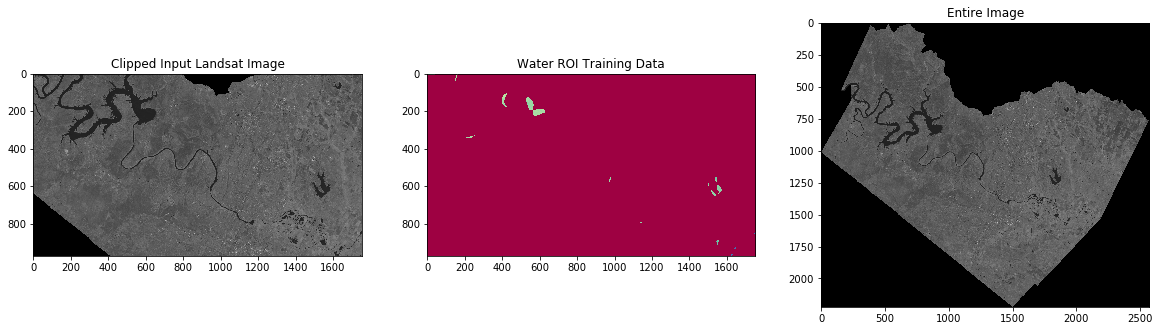

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
ax[0].imshow(in_clipped_data[:,:,3], cmap=plt.cm.Greys_r)
ax[0].set_title('Clipped Input Landsat Image')

ax[1].imshow(in_water_data[:,:,1], cmap=plt.cm.Spectral)
ax[1].set_title('Water ROI Training Data');

ax[2].imshow(in_whole_data[:,:,3], cmap=plt.cm.Greys_r)
ax[2].set_title('Entire Image')

In [4]:
print("Shape of in_water_data: {}".format(in_water_data.shape))
print("Shape of in_clipped_data: {}".format(in_clipped_data.shape))
print("Shape of whole dataset: {}".format(in_whole_data.shape))

Shape of in_water_data: (973, 1753, 4)
Shape of in_clipped_data: (973, 1753, 4)
Shape of whole dataset: (2223, 2572, 4)


In [12]:
in_water_label = in_water_data[:,:,:1]
in_water_label[in_water_label!=0] = 1


in_samples = in_clipped_data.reshape((-1,in_clipped_data.shape[2]))
in_water_train = in_water_label.reshape((-1, in_water_label.shape[2]))
in_whole_inputs = in_whole_data[:,:,:4].reshape((-1, in_whole_data.shape[2]))

in_water_train[in_water_train.ravel()!=0]

in_x = in_samples[in_water_train.ravel()!=0]
in_y = in_water_train[in_water_train.ravel()!=0]


# in_labels = in_water_train[in_water_train>0]
# in_x = in_samples[in_water_train.ravel()>0]

print(in_samples.shape)
print(in_water_train.ravel().shape)
print(in_whole_inputs.shape)
print(in_x.shape)
print(in_y.shape)

(1705669, 4)
(1705669,)
(5717556, 4)
(7497, 4)
(7497, 1)


In [13]:
client = Client()

with joblib.parallel_backend('dask'):
    rfc = RandomForestClassifier(n_estimators=50, oob_score=True).fit(in_x,
                                                                      in_y.ravel())
    preds = rfc.predict(in_samples)
    

C:\Users\moult\Anaconda3\envs\dev\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


Text(0.5, 1.0, 'RFC Results')

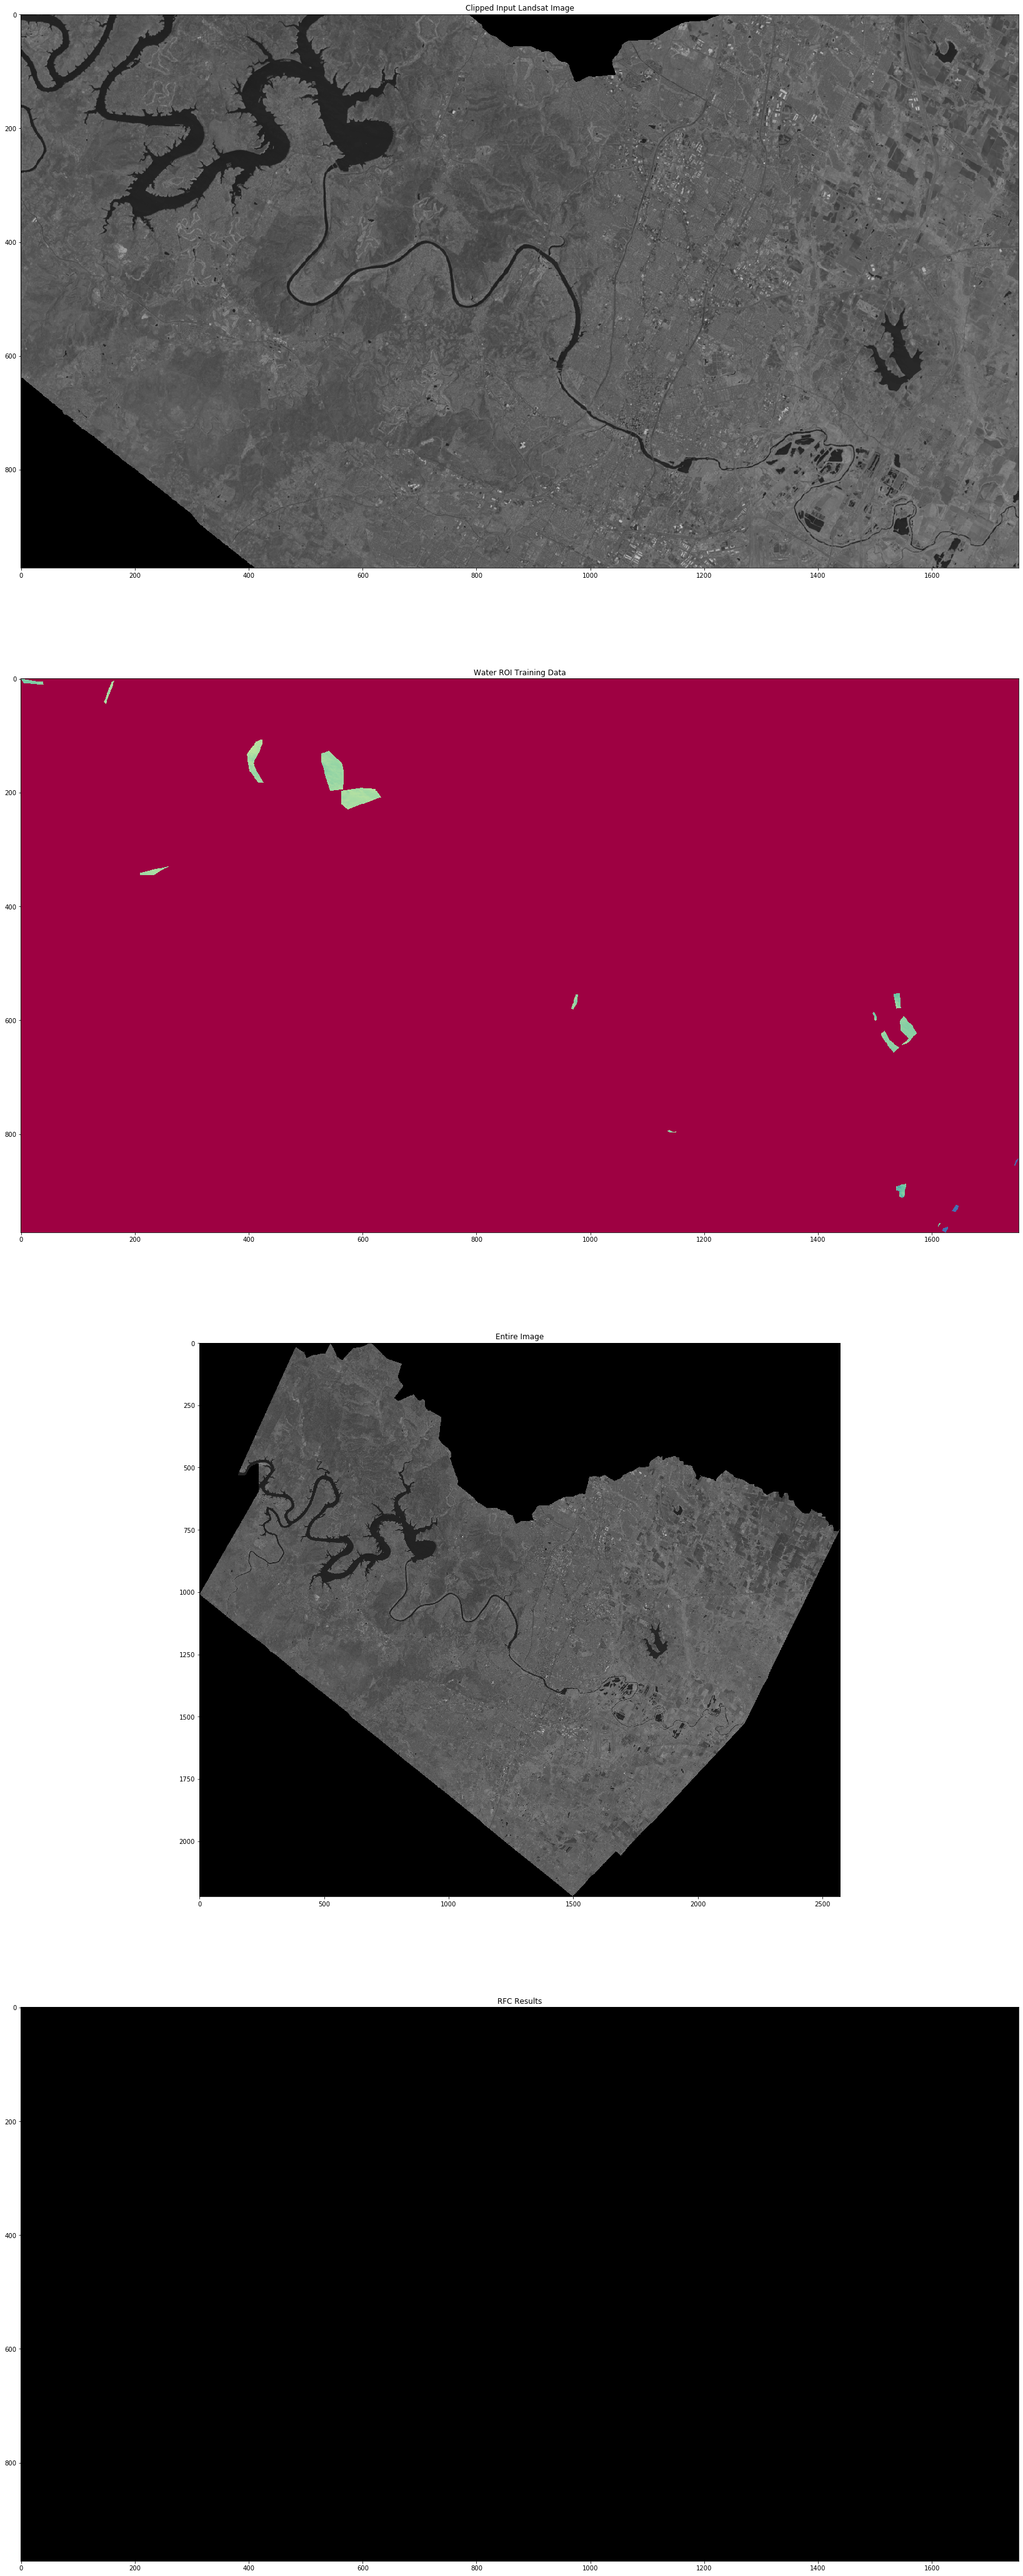

In [15]:
labels = preds.reshape((in_clipped_data.shape[0], in_clipped_data.shape[1]))
print(labels)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(150,75))
ax[0].imshow(in_clipped_data[:,:,3], cmap=plt.cm.Greys_r)
ax[0].set_title('Clipped Input Landsat Image')

ax[1].imshow(in_water_data[:,:,1], cmap=plt.cm.Spectral)
ax[1].set_title('Water ROI Training Data');

ax[2].imshow(in_whole_data[:,:,3], cmap=plt.cm.Greys_r)
ax[2].set_title('Entire Image')

ax[3].imshow(labels, cmap=plt.cm.Greys_r)
ax[3].set_title('RFC Results')

In [ ]:
out_tif = r"..\..\data\Austin_RFC_Class.tif"
tif_driver = gdal.GetDriverByName("GTiff")
in_gt = in_whole_ds.GetGeoTransform()
in_prj = in_whole_ds.GetProjection()

in_srs = osr.SpatialReference(wkt=in_prj)

In [ ]:
out_tif = tif_driver.Create(out_tif, 
                            in_whole_data.shape[1],
                            in_whole_data.shape[0],
                            1,
                            gdal.GDT_Float64)



out_tif.SetProjection(in_srs.ExportToWkt())
out_tif.SetGeoTransform(in_gt)
out_band = out_tif.GetRasterBand(1)
out_band.WriteArray(labels)
out_tif.FlushCache()

In [ ]:
kmeans = KMeans(n_clusters=3).fit_predict(samples)

In [ ]:
labels = kmeans.reshape(in_clipped_data.shape[0], in_clipped_data.shape[1])

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.stack(labels).T)

In [ ]:
gdal.UseExceptions()
gdal.AllRegister()


In [ ]:
img_ds = gdal.Open(in_water_clipped_image, gdal.GA_ReadOnly)

roi_ds = gdal.Open(in_water_mask, gdal.GA_ReadOnly)

In [ ]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
img.shape

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax[0].imshow(in_clipped_data[:,:,3], cmap=plt.cm.Greys_r)
ax[0].set_title('Clipped Input Landsat Image')

ax[1].imshow(in_water_data[:,:,1], cmap=plt.cm.Spectral)
ax[1].set_title('Water ROI Training Data')